In [9]:
import mandelbrot.mandelbrot as mb
import mandelbrot.visualisation as viz
import mandelbrot.utils as utils
import benchmark
import numpy as np
from numba import set_num_threads
import matplotlib.pyplot as plt

In [4]:
complex_array = utils.generate_complex_array(real_range=(-2, 1), img_range=(-1.5, 1.5), size=1000)

In [10]:
mb.mandelbrot_set_naive(np.array([complex(0.5, 0.5), complex(-0.5, -0.5)]))

IndexError: tuple index out of range

## Initial implementation

The mandelbrot function is implemented initally as a for loop, as described in the project description. Then a wrapper function is defined, that repeats this function on each element of an array containing complex values.


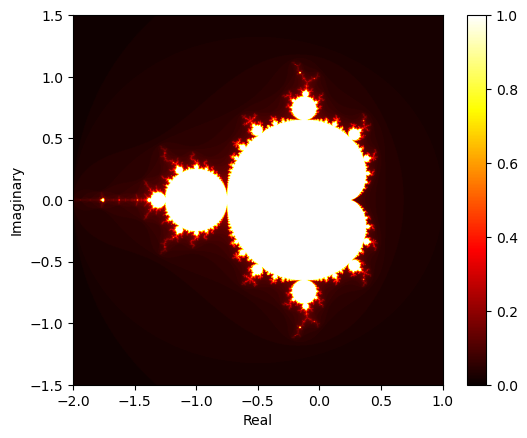

In [5]:
viz.plot_mandelbrot_set(mb.mandelbrot_set_naive(complex_array))

Running the function and plotting the resulting stability array shows the recogniseable mandelbrot set. 

## Different implementations
In addition to the naive approach, a couple of different approahces are implemented. Firstly, a numba approach is tried, where both the internal mandelbrot function and the wrapper function are decorated with the jit flag. Secondly, a vectorised approach is tested, where the array of complexed values gets multiplied by positionwise multiplication and additions. The vectorised version also masks entries in the array after they have converged. The vectorised version is also implemented with the jit flag. 

In [4]:
benchmarks = {}

set_num_threads(1)
for method in [mb.mandelbrot_set_naive, 
    mb.mandelbrot_set_vectorised, 
    mb.mandelbrot_set_vectorised_numba,
    mb.mandelbrot_set_numba, 
    mb.mandelbrot_set_numba_parallel]:
    times = []
    resolution = []
    for res in [100, 400, 800, 1000, 2000]:
        bench = benchmark.time_method(method, resolution=res)
        times.append(list(bench.values())[0])
        resolution.append(res)
    benchmarks[method.__name__.replace("mandelbrot_set_", "")] = [times, resolution]



Text(0.5, 1.0, 'Execution time of mandelbrot set methods')

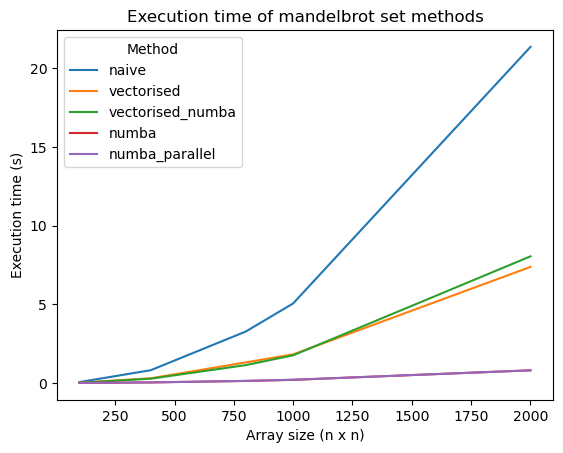

In [5]:
for method in benchmarks.keys():
    plt.plot(benchmarks[method][1], benchmarks[method][0], label=method)
plt.legend(loc='upper left', title="Method")
plt.xlabel('Array size (n x n)')
plt.ylabel('Execution time (s)')
plt.title('Execution time of mandelbrot set methods')

In [6]:
benchmarks_parallel = {}
res = 30000


times = []
core_utilisation = []
processes = [1, 4, 8]
for proc in processes:
    set_num_threads(proc)
    bench = benchmark.time_method(mb.mandelbrot_set_numba_parallel, resolution=res)
    if proc == 1:
        one_core_time = list(bench.values())[0]

    times.append(list(bench.values())[0])
    core_utilisation.append(one_core_time/(proc*list(bench.values())[0]))

bench = benchmark.time_method(mb.mandelbrot_set_numba, resolution=res)
benchmarks_parallel["Numba"] = [list(bench.values())[0], 1, one_core_time/list(bench.values())[0]]


benchmarks_parallel["Numba Parallel"] = [times, processes, core_utilisation]

: 

: 

Text(0.5, 1.0, 'Parallel execution time of mandelbrot set')

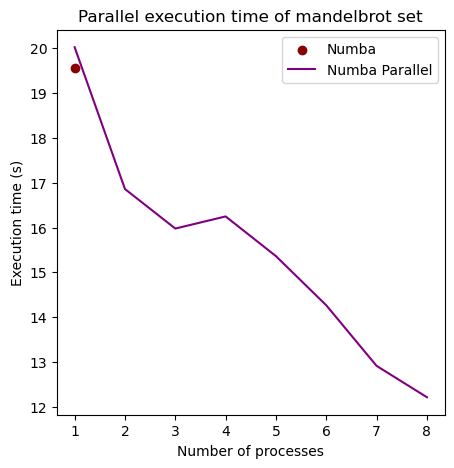

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
plt.scatter(benchmarks_parallel["Numba"][1], benchmarks_parallel["Numba"][0], label="Numba", c = "darkred", )
plt.plot(benchmarks_parallel["Numba Parallel"][1], benchmarks_parallel["Numba Parallel"][0], label="Numba Parallel", c = "purple")
plt.legend()
plt.xlabel('Number of processes')
plt.ylabel('Execution time (s)')
plt.title('Parallel execution time of mandelbrot set')

/tmp/ipykernel_3974/1729475186.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


Text(0.5, 1.0, 'Utilisation of cores during parallel execution')

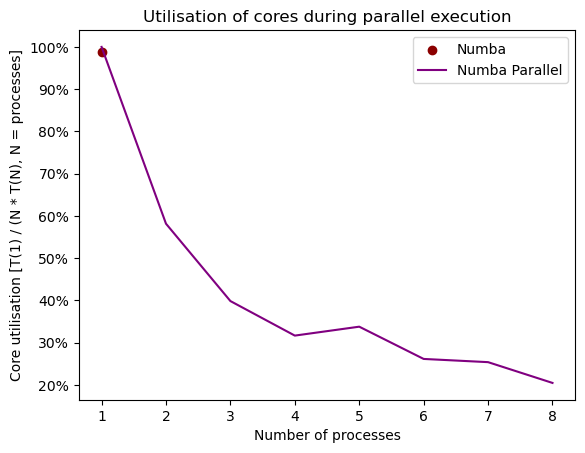

In [ ]:
plt.scatter(
    benchmarks_parallel["Numba"][1], 
    benchmarks_parallel["Numba"][2], 
    label="Numba", c = "darkred"
)
plt.plot(
    benchmarks_parallel["Numba Parallel"][1], 
    benchmarks_parallel["Numba Parallel"][2], 
    label="Numba Parallel", c = "purple"
)
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.legend()
plt.xlabel('Number of processes')
plt.ylabel('Core utilisation [T(1) / (N * T(N), N = processes]')
plt.title('Utilisation of cores during parallel execution')

In [ ]:
complex_array_1e4 = utils.generate_complex_array(real_range=(-2, 1), img_range=(-1.5, 1.5), size=10000)

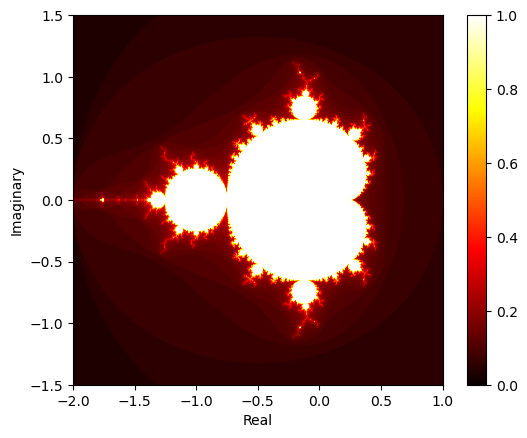

In [36]:
set_num_threads(4)
viz.plot_mandelbrot_set(mb.mandelbrot_set_numba_parallel(complex_array_1e4)**(3/4), extent= [-2, 1, -1.5, 1.5])